# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode STL objects based on their coordinate vectors as input.

This VAE is based off of the one explored in the vae_examples notebook from [Jan Hendrik Metzen's blog post](https://jmetzen.github.io/2015-11-27/vae.html).

## Notes

* The original VAE used a softplus activation function. This is not ideal for the STL usecase, as we need to model both negative and positive outputs. Thus, we will use [tanh](https://sefiks.com/2017/01/29/hyperbolic-tangent-as-neural-network-activation-function/).

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

## Data Import

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data import THINGI10K_INDEX
from data.stl import save_vectors_as_stl, plot_mesh
from models import MODEL_DIR

thingi = Thingi10k.init10k(pctile=.8)
n_samples = len(thingi)
n_samples

7956

In [3]:
# some models are quite large and cause this architecture to hit a memory error
# also tensors cannot be greater than 2 GB!
# to calculate size in bytes of tensor, take size of architecture layer * vector length * 4

#n_input = 90000  # multiple of 9!! vertices come in 3! any less and you're cutting off vital info
n_input = thingi.max_length()

print('n_samples: {}'.format(n_samples))
print('n_input: {}'.format(n_input))
size_bytes = n_input * 100 * 4
print('size: {} bytes'.format(size_bytes))
size_gb = size_bytes / 1024 / 1024 / 1024
print('size: {:.2f} gb'.format(size_bytes / 1024 / 1024 / 1024))
assert size_gb < 2

n_samples: 7956
n_input: 644490
size: 257796000 bytes
size: 0.24 gb


In [4]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)


class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.tanh, 
                 learning_rate=0.001, batch_size=100, ckpt_dir='stl_vae'):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        ### original tutorial used tf.mul; I've updated it to tf.multiply for tf 1.0+
        ### https://stackoverflow.com/questions/42217059/tensorflowattributeerror-module-object-has-no-attribute-mul
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        # Jack: to make not bernoulli, changed to tanh from sigmoid
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def train(self, generator, training_epochs=10, display_step=1, save_step=1):
        # Training cycle
        start = time.time()
        for epoch_num, epoch in enumerate(range(training_epochs)):
            avg_cost = 0.0

            for batch_num, batch in enumerate(generator()):
                if len(batch) != self.batch_size:
                    continue
                #print('Epoch: {}, Batch: {}'.format(epoch_num, batch_num))

                # Fit training using batch data
                cost = self.partial_fit(batch)

                # Compute average loss
                avg_cost += cost / n_samples * len(batch)

            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), 
                      "cost=", "{:.9f}".format(avg_cost),
                      "Elapsed time: {} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                self.visualize_reconstruction(batch[0])

            if epoch % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
    def visualize_reconstruction(self, x_sample, sample_name=None):
        # generate a sample from the sample
        x_reconstruct = self.reconstruct(x_sample.reshape([-1, n_input]))

        # reshape into 3x3 vertice
        x_sample_vectors = x_sample.reshape([-1, 3, 3])
        x_reconstruct_vectors = x_reconstruct[0].reshape([-1, 3, 3])
        
        title = '' if not sample_name else ': {}'.format(sample_name)
        plot_mesh(x_sample_vectors, title='Original' + title)
        plot_mesh(x_reconstruct_vectors, title='Autoencoded' + title)
        
        return

In [5]:
# to consider when building the architecture
# tensors can only be so big!
# https://stackoverflow.com/questions/46941747/tensorflow-error-cannot-parse-tensor-from-proto
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=n_input, # length of STL vectors
         n_z=20)  # dimensionality of latent space

BATCH_SIZE = 100
vae = VariationalAutoencoder(network_architecture, 
                             learning_rate=0.001, 
                             batch_size=BATCH_SIZE)

Epoch: 0001 cost= 133676.110305901 Elapsed time: 10.3293017745018 mins
Generation Example:


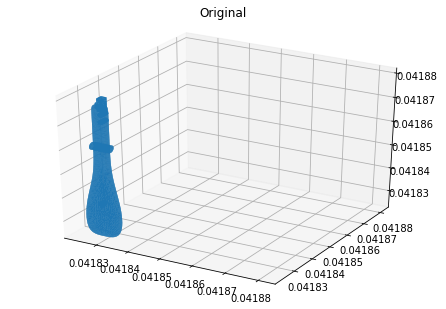

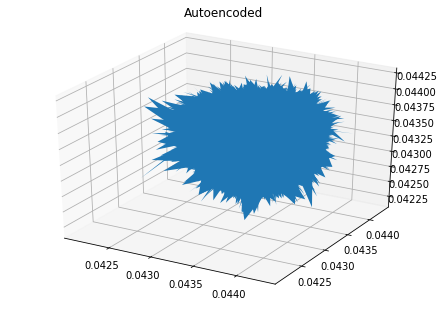

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-0.ckpt
Epoch: 0006 cost= 111228.864712952 Elapsed time: 62.7643962264061 mins
Generation Example:


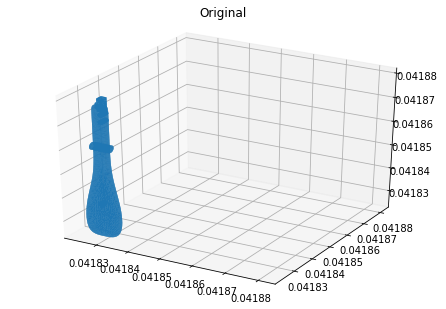

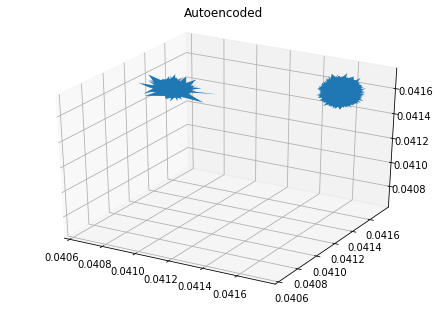

Epoch: 0011 cost= 111225.198160194 Elapsed time: 115.38575112422308 mins
Generation Example:


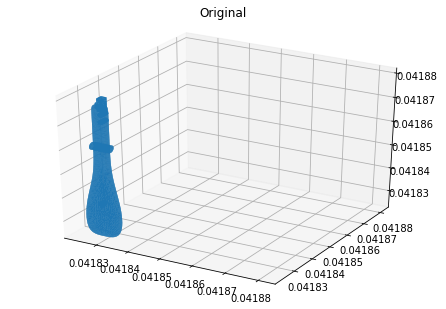

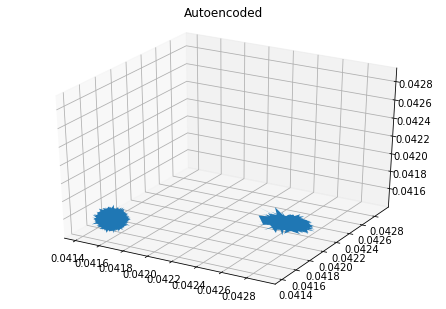

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-10.ckpt
Epoch: 0016 cost= 111224.416811997 Elapsed time: 168.0234549244245 mins
Generation Example:


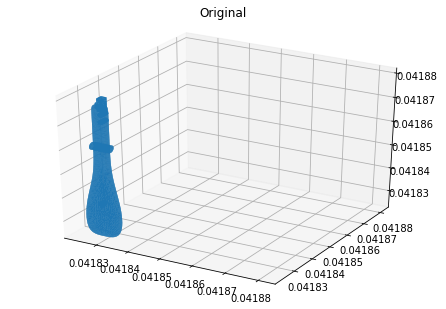

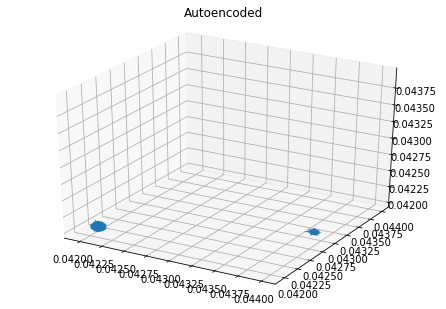

Epoch: 0021 cost= 111221.747148379 Elapsed time: 219.07168252468108 mins
Generation Example:


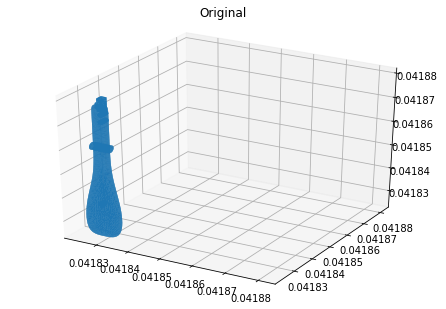

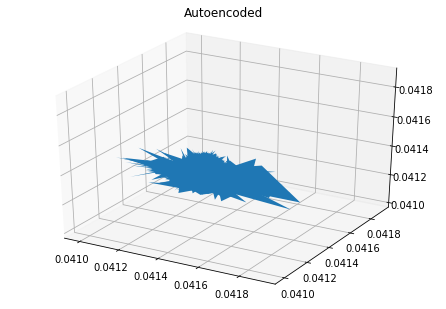

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-20.ckpt
Epoch: 0026 cost= 111227.503122643 Elapsed time: 271.71878660122553 mins
Generation Example:


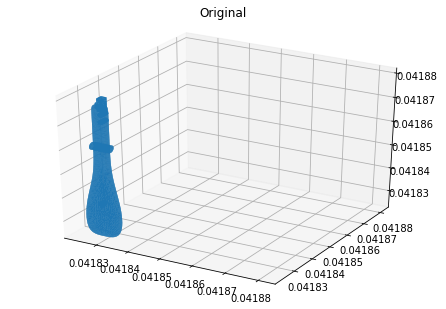

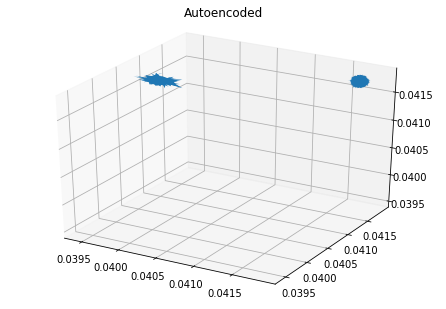

Epoch: 0031 cost= 111221.567940077 Elapsed time: 323.91659203370415 mins
Generation Example:


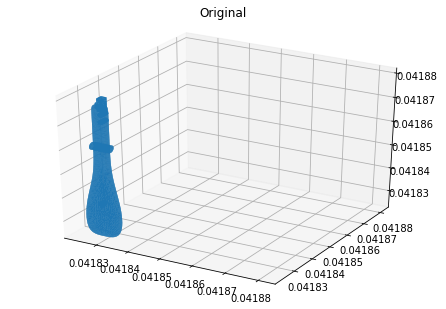

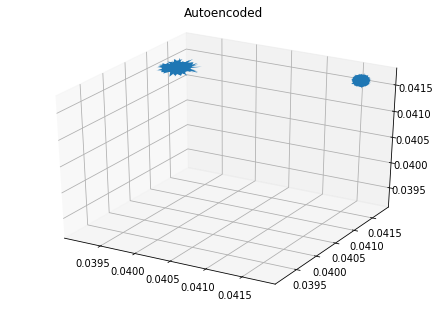

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-30.ckpt


In [ ]:
generator = lambda: thingi.batchmaker(BATCH_SIZE, normalize=True, flat=True, pad_length=n_input, filenames=False)

vae.train(generator, training_epochs=80, display_step=5, save_step=10)

# 10 epochs produces the same stl dump regardless of input; perhaps a sign of overtraining
# "best" reconstructed image was from a model trained on 80 epochs on Thingi10:
# https://github.com/workmanjack/3d-form/blob/047081c799eb866cdfcc81ee653ac30d7698cffe/notebooks/stl_vae.ipynb
#
# it is looking like same results (that two cluster split) is a result of undertraining; 16 epochs on full dataset
# yielded the two cluster split (and so did all previous), then 21 epochs on full dataset yielded a single,
# more concise blob!
# 

In [6]:
# get an example from thingi10k
# todo... really should be able to pull an example without batch generator...
for batch in thingi.batchmaker(10, normalize=True, flat=True, pad_length=n_input, filenames=True):
    stl_file, x_sample = batch[5]
    break

# generate a sample from the sample
x_reconstruct = vae.reconstruct(x_sample.reshape([-1, n_input]))

# reshape into 3x3 vertices
print('Source: {}'.format(stl_file))
x_sample_vectors = x_sample.reshape([-1, 3, 3])
x_reconstruct_vectors = x_reconstruct[0].reshape([-1, 3, 3])

Source: /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/99812.stl


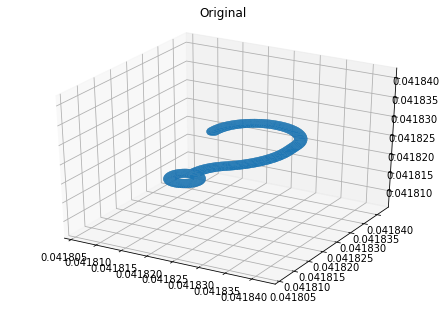

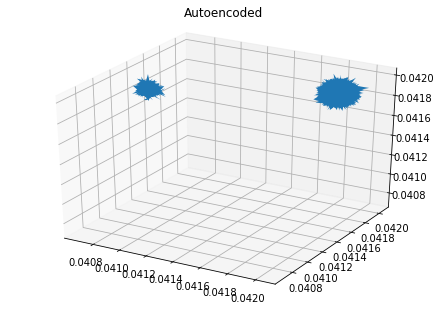

In [7]:
from data.stl import plot_mesh


plot_mesh(x_sample_vectors, title='Original')
plot_mesh(x_reconstruct_vectors, title='Autoencoded')

In [ ]:
save_vectors_as_stl(vectors, 'first_vae_stl.stl')

## Restoring and Reusing a Model

In [7]:
vae.restore(os.path.join(MODEL_DIR, 'stl_vae', 'model_epoch-70.ckpt'))

INFO:tensorflow:Restoring parameters from /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-70.ckpt


In [8]:
# get an example from thingi10k
# todo... really should be able to pull an example without batch generator...
for batch in thingi.batchmaker(10, normalize=True, flat=True, pad_length=n_input, filenames=True):
    stl_file, x_sample = batch[5]
    break

# generate a sample from the sample
x_reconstruct = vae.reconstruct(x_sample.reshape([-1, n_input]))

# reshape into 3x3 vertices
print('Source: {}'.format(stl_file))
x_sample_vectors = x_sample.reshape([-1, 3, 3])
x_reconstruct_vectors = x_reconstruct[0].reshape([-1, 3, 3])

Source: /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/99812.stl


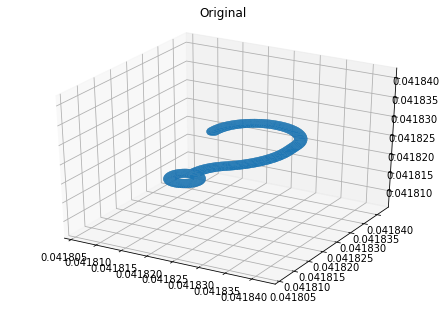

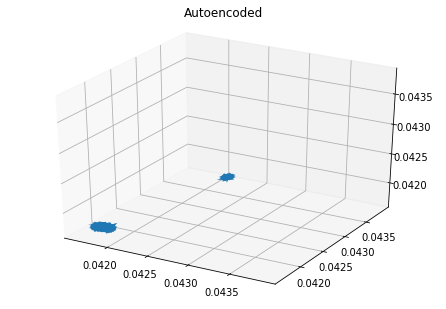

In [9]:
from data.stl import plot_mesh


plot_mesh(x_sample_vectors, title='Original')
plot_mesh(x_reconstruct_vectors, title='Autoencoded')